<a href="https://colab.research.google.com/github/genarioazevedoufape/reconhecimento_padroes/blob/main/2_parte_Projeto_RP_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spaceship Titanic
Equipe:

1.   Genário Correia
2.   João Victor Iane
3.   Matheus Henrique

In [ ]:
# Importando bibliotecas
import warnings

# Bibliotecas essenciais
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from scipy.stats import zscore
from scipy.stats.mstats import winsorize

# Scikit-learn Modules
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    StratifiedKFold,
    KFold
)
from sklearn.preprocessing import (
    StandardScaler,
    LabelEncoder
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier
)
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc
)
from sklearn.pipeline import Pipeline

# Configurações
warnings.filterwarnings("ignore")

### Carregamento dos dados

In [ ]:
full_train = pd.read_csv('https://raw.githubusercontent.com/genarioazevedoufape/estudos_data_science/refs/heads/main/Data/train.csv')
print('Rows:', full_train.shape[0], ' | Columns:', full_train.shape[1])

full_test = pd.read_csv('https://raw.githubusercontent.com/genarioazevedoufape/estudos_data_science/refs/heads/main/Data/test.csv')
print('Rows:', full_test.shape[0], ' | Columns:', full_test.shape[1])

submission_index = pd.read_csv('https://raw.githubusercontent.com/genarioazevedoufape/estudos_data_science/refs/heads/main/Data/sample_submission.csv')
print('Rows:', submission_index.shape[0], ' | Columns:', submission_index.shape[1])
submission_index = full_test["PassengerId"]

Rows: 8693  | Columns: 14
Rows: 4277  | Columns: 13
Rows: 4277  | Columns: 2


In [ ]:
# Exibir informações básicas
def overview(df, name):
    print(f'\n{name} Dataset:')
    print(df.info())
    print(df.describe())
    print(f'Valores Ausentes:\n{df.isnull().sum()}')
    print('-' * 50)

overview(full_train, "Train")
overview(full_test, "Test")


Train Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
None
               Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  8514.000000   8512.000000   8510.000

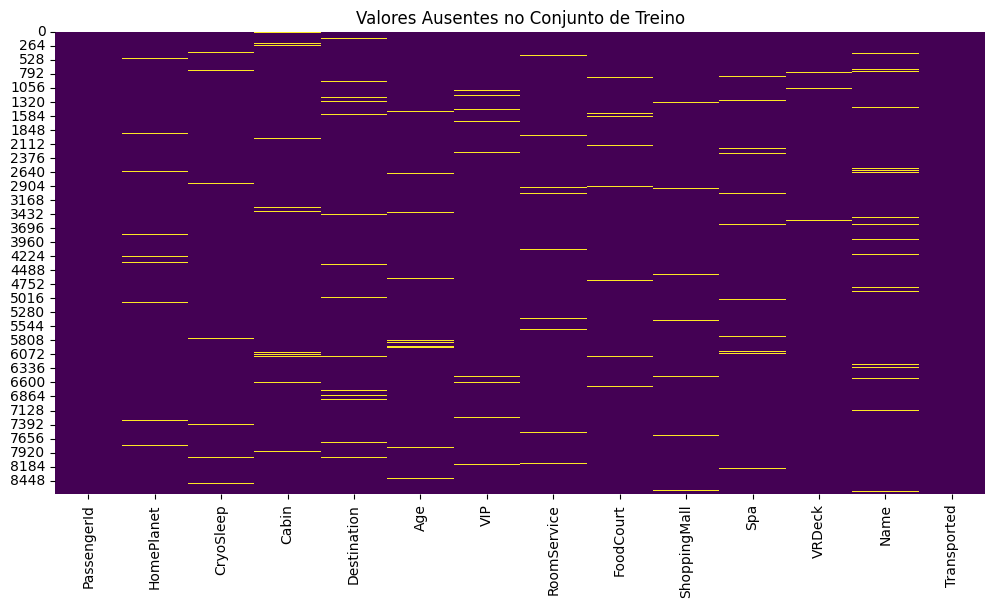

In [ ]:
# Visualização de valores ausentes
plt.figure(figsize=(12, 6))
sns.heatmap(full_train.isnull(), cbar=False, cmap='viridis')
plt.title('Valores Ausentes no Conjunto de Treino')
plt.show()

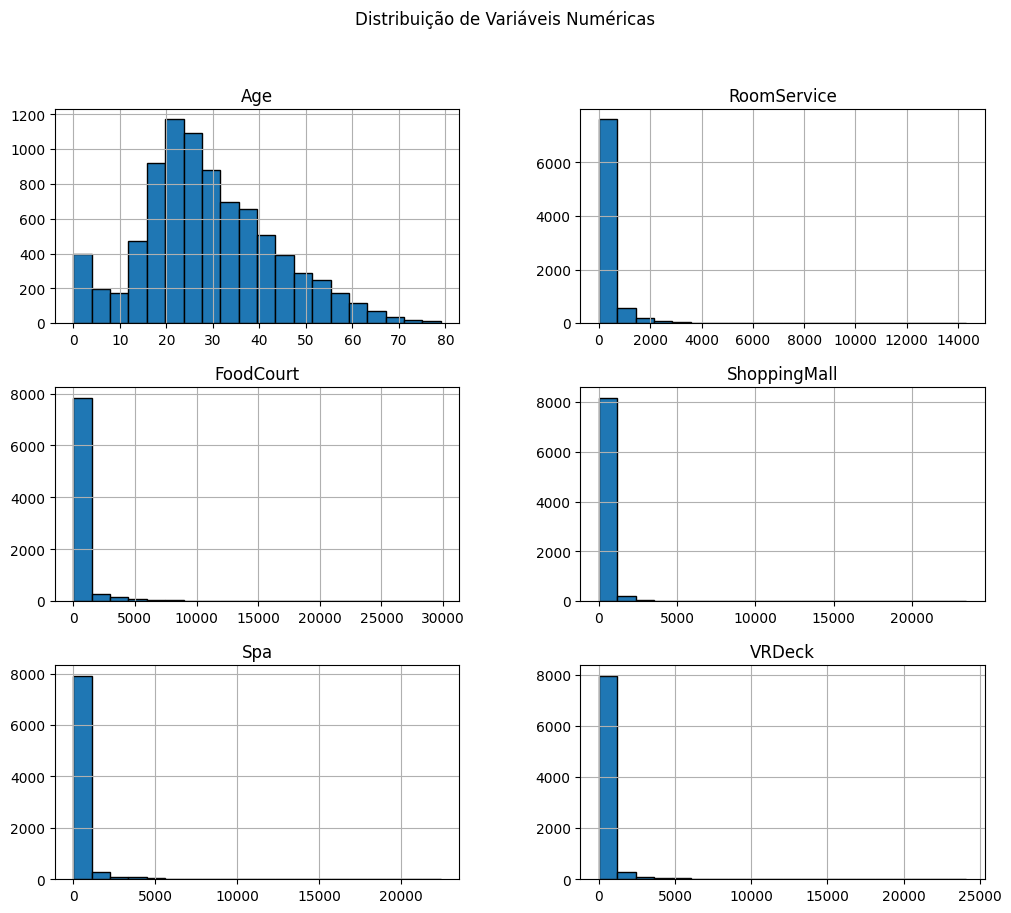

In [ ]:
# Distribuição das variáveis numéricas
numerical_columns = full_train.select_dtypes(include=[np.number]).columns
full_train[numerical_columns].hist(figsize=(12, 10), bins=20, edgecolor='black')
plt.suptitle('Distribuição de Variáveis Numéricas')
plt.show()

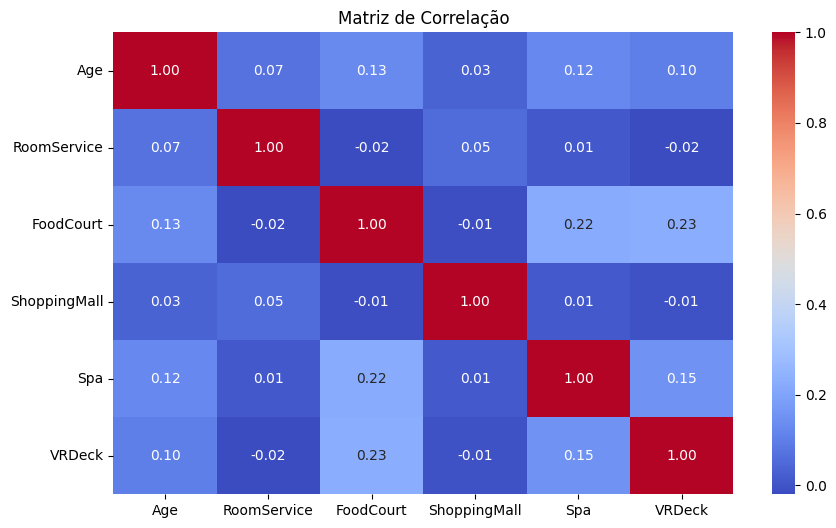

In [ ]:
# Correlação entre variáveis numéricas
plt.figure(figsize=(10, 6))
sns.heatmap(full_train[numerical_columns].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação')
plt.show()

### Pré-processamento

In [ ]:
def preprocess_data(df, is_train=True, age_median=None):
    """
    Args:
        df: DataFrame a ser processado
        is_train: Indica se é o conjunto de treino
        age_median: Valor da mediana de idade para consistência entre treino/teste

    Returns:
        DataFrame processado e (se is_train=True) a mediana de idade calculada
    """
    # Criar cópia para evitar modificar o dataframe original
    df = df.copy()

    # 1. Tratar valores ausentes de forma consistente
    fill_values = {
        'HomePlanet': 'Unknown',
        'Destination': 'Unknown',
        'Cabin': 'Unknown/Unknown/Unknown',
        'CryoSleep': False,
        'VIP': False,
    }
    df.fillna(fill_values, inplace=True)

    # Calcular/Usar mediana de idade consistente
    if is_train or age_median is None:
        age_median = df['Age'].median()
    df['Age'].fillna(age_median, inplace=True)

    # Para gastos - zero faz sentido para quem não gastou
    spending_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    df[spending_cols] = df[spending_cols].fillna(0)

    # 2. Engenharia de features mais robusta
    # Extrair informações da cabine com tratamento de erros
    cabin_split = df['Cabin'].str.split('/', expand=True)
    df['Deck'] = cabin_split[0].where(cabin_split[0].notna(), 'Unknown')
    df['Side'] = cabin_split[2].where(cabin_split[2].notna(), 'Unknown')

    # Criar features adicionais úteis
    df['Total_Spending'] = df[spending_cols].sum(axis=1)
    df['No_Spending'] = (df['Total_Spending'] == 0).astype(int)

    # 3. Converter tipos de dados de forma segura
    df['CryoSleep'] = df['CryoSleep'].astype(int)
    df['VIP'] = df['VIP'].astype(int)

    # 4. One-Hot Encoding otimizado
    categorical_cols = ['HomePlanet', 'Destination', 'Deck', 'Side']

    # Para conjuntos grandes, considerar Sparse=True
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True, dtype=np.int8)

    # 5. Remoção segura de colunas
    cols_to_drop = ['Name', 'PassengerId', 'Cabin']
    df.drop(columns=[col for col in cols_to_drop if col in df.columns], inplace=True)

    return df if not is_train else (df, age_median)

def preprocess_datasets(train, test):
    """
    Args:
        train: DataFrame de treino
        test: DataFrame de teste

    Returns:
        Tupla com (train_processed, test_processed)
    """
    # Processar treino e obter parâmetros
    train_processed, age_median = preprocess_data(train, is_train=True)

    # Processar teste com parâmetros do treino
    test_processed = preprocess_data(test, is_train=False, age_median=age_median)

    # Alinhar colunas de forma mais eficiente
    train_cols = set(train_processed.columns)
    test_cols = set(test_processed.columns)

    # Adicionar colunas faltantes no teste
    for col in train_cols - test_cols:
        test_processed[col] = 0

    # Remover colunas extras no teste (não deve acontecer)
    for col in test_cols - train_cols:
        test_processed.drop(col, axis=1, inplace=True)

    # Garantir mesma ordem de colunas
    test_processed = test_processed[train_processed.columns]

    return train_processed, test_processed

In [ ]:
# Aplicar pré-processamento aos datasets
full_train, full_test = preprocess_datasets(full_train, full_test)

### Verificação de Outlies

Número de outliers detectados por coluna (zscore):
CryoSleep                      0
Age                           30
VIP                          199
RoomService                  175
FoodCourt                    167
ShoppingMall                 130
Spa                          176
VRDeck                       166
Total_Spending               188
No_Spending                    0
HomePlanet_Europa              0
HomePlanet_Mars                0
HomePlanet_Unknown           201
Destination_PSO J318.5-22    796
Destination_TRAPPIST-1e        0
Destination_Unknown          182
Deck_B                       779
Deck_C                       747
Deck_D                       478
Deck_E                         0
Deck_F                         0
Deck_G                         0
Deck_T                         5
Deck_Unknown                 199
Side_S                         0
Side_Unknown                 199
dtype: int64


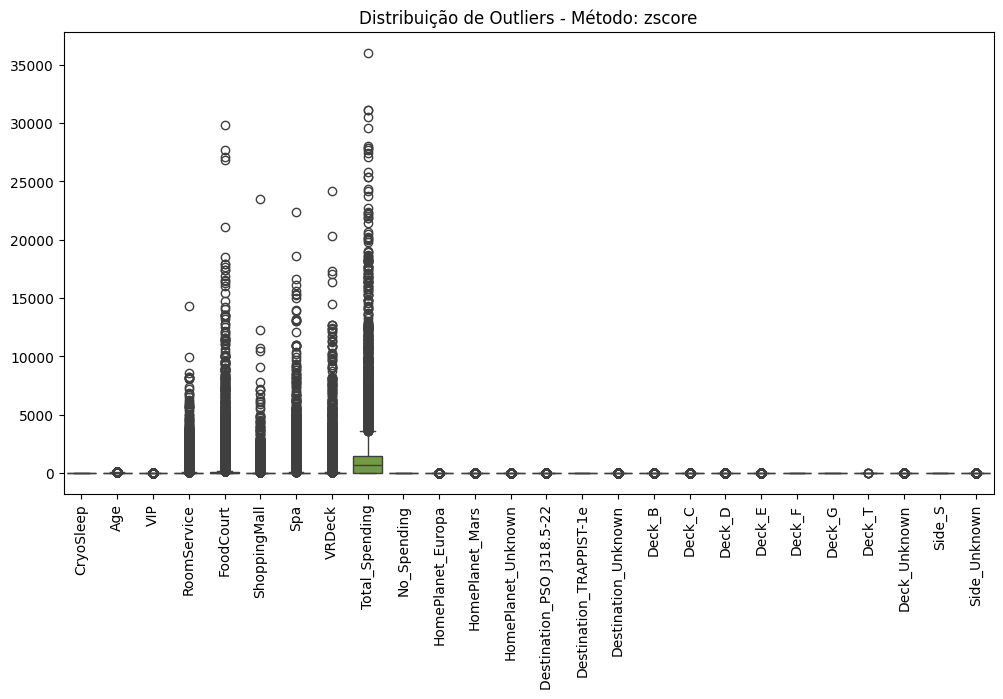

In [ ]:
# Função para identificar outliers
def detect_outliers(df, method='zscore', threshold=3, plot=True):
    df_numeric = df.select_dtypes(include=[np.number])

    if method == 'zscore':
        from scipy.stats import zscore
        z_scores = np.abs(zscore(df_numeric))
        outliers = (z_scores > threshold)
    elif method == 'iqr':
        Q1 = df_numeric.quantile(0.25)
        Q3 = df_numeric.quantile(0.75)
        IQR = Q3 - Q1
        outliers = ((df_numeric < (Q1 - 1.5 * IQR)) | (df_numeric > (Q3 + 1.5 * IQR)))
    else:
        raise ValueError("Método inválido. Escolha 'zscore' ou 'iqr'.")

    outlier_counts = outliers.sum()
    print(f"Número de outliers detectados por coluna ({method}):")
    print(outlier_counts)

    if plot:
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=df_numeric)
        plt.xticks(rotation=90)
        plt.title(f"Distribuição de Outliers - Método: {method}")
        plt.show()

    return df[outliers.any(axis=1)]

outliers = detect_outliers(full_train, method='zscore', threshold=3)

In [ ]:
def treat_outliers(df):
    df = df.copy()

    # 1. Definir colunas para tratamento
    continuous_cols = ['Age', 'RoomService', 'FoodCourt',
                      'ShoppingMall', 'Spa', 'VRDeck', 'Total_Spending']

    # 2. Aplicar winsorization apenas nas colunas contínuas
    for col in continuous_cols:
        if col in df.columns:
            df[col] = winsorize(df[col], limits=[0.01, 0.01])

    # 3. Tratamento especial para Age (garantir que não fique fora de limites realistas)
    if 'Age' in df.columns:
        df['Age'] = df['Age'].clip(lower=0, upper=100)

    return df

full_train = treat_outliers(full_train)
full_test = treat_outliers(full_test)

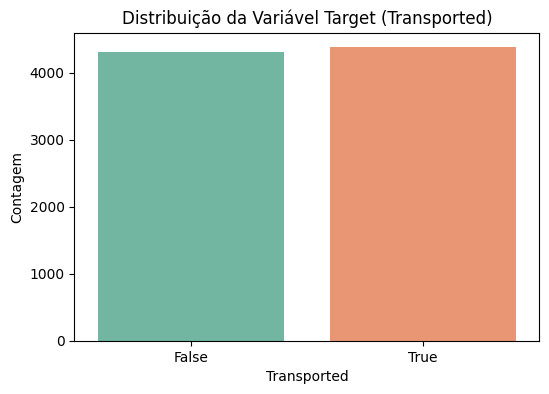

Transported
True     0.503624
False    0.496376
Name: proportion, dtype: float64


In [ ]:
# Visualização da distribuição da variável target
plt.figure(figsize=(6, 4))
sns.countplot(x='Transported', data=full_train, palette='Set2')
plt.title("Distribuição da Variável Target (Transported)")
plt.xlabel("Transported")
plt.ylabel("Contagem")
plt.show()

print(full_train['Transported'].value_counts(normalize=True))

### Houldout

In [ ]:
# Separar features e target
X = full_train.drop(columns=['Transported'])
y = full_train['Transported'].astype(int)

In [ ]:
# Divisão dos dados em treino e validação
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Normalização dos dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

### BASELINE - KNN

In [ ]:
# KNN
model8 = KNeighborsClassifier(n_neighbors=10)

model8.fit(X_train, y_train)

y_pred = model8.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f"Acurácia: {accuracy}")

print("Relatório de Classificação:")
print(classification_report(y_val, y_pred))

print("Matriz de Confusão:")
print(confusion_matrix(y_val, y_pred))

Acurácia: 0.7872340425531915
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.76      0.83      0.79       861
           1       0.82      0.75      0.78       878

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739

Matriz de Confusão:
[[712 149]
 [221 657]]


### Cross Validation

In [ ]:
# Criar a instância do StratifiedKFold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lista de classificadores para comparação com Pipeline
classifiers = [
    ("KNN", KNeighborsClassifier(n_neighbors=10)),
    ("Random Forest", RandomForestClassifier(n_estimators=50, random_state=42)),
    ("SVM", SVC(kernel='linear', probability=True, random_state=42)),
    ("Gradient Boosting", GradientBoostingClassifier(n_estimators=50, max_depth=3, random_state=42)),
    ("MLP", MLPClassifier(hidden_layer_sizes=(30, 50), max_iter=200, random_state=42))
]


KNN:
 - Acurácia Média = 0.7787, Desvio Padrão = 0.0210
 - F1-score Médio = 0.7688
 - ROC AUC Médio = 0.8647

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.76      0.83      0.79       861
           1       0.82      0.75      0.78       878

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739


Matriz de Confusão:
[[712 149]
 [221 657]]

Random Forest:
 - Acurácia Média = 0.7939, Desvio Padrão = 0.0128
 - F1-score Médio = 0.7892
 - ROC AUC Médio = 0.8664

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.76      0.80      0.78       861
           1       0.80      0.76      0.78       878

    accuracy                           0.78      1739
   macro avg       0.78      0.78      0.78      1739
weighted avg       0.78      0.78      0.78      1739


Matriz de Con

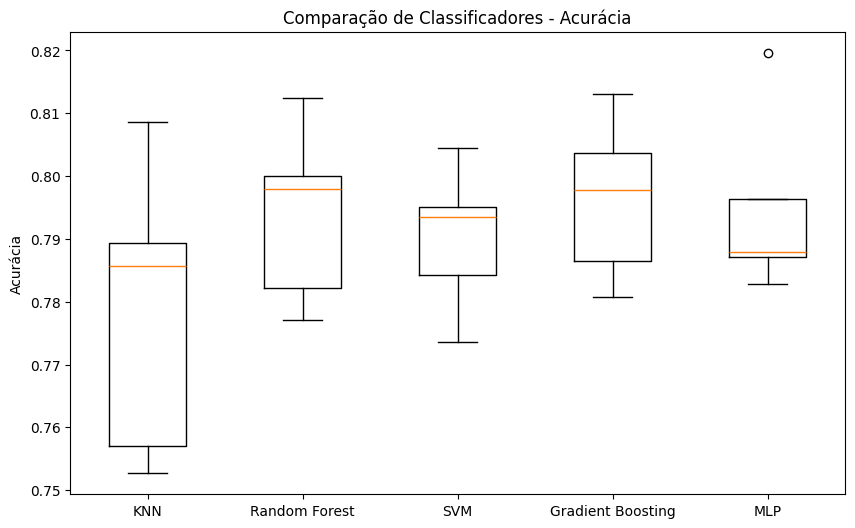

In [ ]:
# Criar listas para armazenar as métricas por fold
metrics = {
    "accuracy": [],
    "f1_score": [],
    "roc_auc": []
}

# Lista de nomes dos classificadores
names = [name for name, _ in classifiers]

for name, clf in classifiers:
    # Pipeline sem o StandardScaler (já aplicado anteriormente)
    model = clf

    accuracy_list = []
    f1_list = []
    roc_auc_list = []

    for train_idx, test_idx in kfold.split(X_train, y_train):
        # Use array indexing instead of .iloc
        X_fold_train, X_fold_test = X_train[train_idx], X_train[test_idx]
        y_fold_train, y_fold_test = y_train.iloc[train_idx], y_train.iloc[test_idx]

        model.fit(X_fold_train, y_fold_train)
        y_pred = model.predict(X_fold_test)
        y_pred_proba = model.predict_proba(X_fold_test)[:, 1] if hasattr(model, "predict_proba") else None

        accuracy_list.append(accuracy_score(y_fold_test, y_pred))
        f1_list.append(f1_score(y_fold_test, y_pred))

        if y_pred_proba is not None:
            roc_auc_list.append(roc_auc_score(y_fold_test, y_pred_proba))

    # Armazenar as listas completas
    metrics["accuracy"].append(accuracy_list)
    metrics["f1_score"].append(f1_list)
    metrics["roc_auc"].append(roc_auc_list if roc_auc_list else [np.nan] * len(accuracy_list))

    print(f"\n{name}:")
    print(f" - Acurácia Média = {np.mean(accuracy_list):.4f}, Desvio Padrão = {np.std(accuracy_list):.4f}")
    print(f" - F1-score Médio = {np.mean(f1_list):.4f}")
    if roc_auc_list:
        print(f" - ROC AUC Médio = {np.mean(roc_auc_list):.4f}")

    # Treinar com todos os dados para exibir relatório final
    model.fit(X_train, y_train)
    y_pred_final = model.predict(X_val)

    print("\nRelatório de Classificação:")
    print(classification_report(y_val, y_pred_final))

    print("\nMatriz de Confusão:")
    print(confusion_matrix(y_val, y_pred_final))

# Plotar resultados comparativos
plt.figure(figsize=(10, 6))
plt.boxplot(metrics["accuracy"], labels=names)
plt.title("Comparação de Classificadores - Acurácia")
plt.ylabel("Acurácia")
plt.show()

In [ ]:
!pip install optuna

In [ ]:
def objective(trial):
    params = {
        'hidden_layer_sizes': trial.suggest_categorical('hidden_layer_sizes', [(30,), (50,), (30, 50)]),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh']),
        'solver': trial.suggest_categorical('solver', ['adam', 'sgd']),
        'alpha': trial.suggest_float('alpha', 0.0001, 0.1, log=True),
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'adaptive']),
        'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128])
    }

    model = MLPClassifier(max_iter=100, random_state=42, **params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return accuracy_score(y_val, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print("Melhores hiperparâmetros:", study.best_params)

[I 2025-03-25 15:14:24,654] A new study created in memory with name: no-name-203bc6dd-f872-43dd-ae53-29c3476dee0f
[I 2025-03-25 15:14:44,187] Trial 0 finished with value: 0.7901092581943646 and parameters: {'hidden_layer_sizes': (30, 50), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0032864102870220914, 'learning_rate': 'adaptive', 'batch_size': 32}. Best is trial 0 with value: 0.7901092581943646.
[I 2025-03-25 15:14:51,980] Trial 1 finished with value: 0.7843588269120184 and parameters: {'hidden_layer_sizes': (50,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.007886443007643185, 'learning_rate': 'constant', 'batch_size': 128}. Best is trial 0 with value: 0.7901092581943646.
[I 2025-03-25 15:15:00,240] Trial 2 finished with value: 0.7918343875790684 and parameters: {'hidden_layer_sizes': (30,), 'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.00015288568040347045, 'learning_rate': 'constant', 'batch_size': 64}. Best is trial 2 with value: 0.7918343875790684.
[I 2025-03-25 

Melhores hiperparâmetros: {'hidden_layer_sizes': (30,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.09916016351756564, 'learning_rate': 'adaptive', 'batch_size': 32}


Acurácia do modelo otimizado: 0.8004600345025877

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       861
           1       0.81      0.79      0.80       878

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739


Matriz de Confusão:
[[694 167]
 [180 698]]


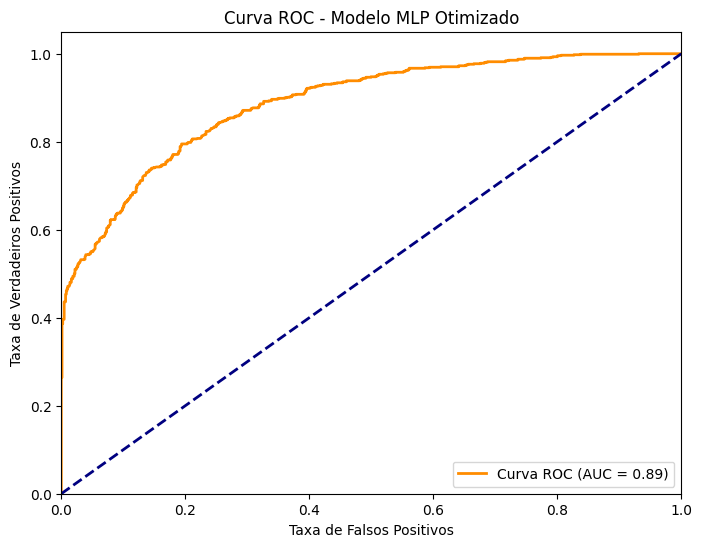


AUC Score: 0.8866


In [ ]:
# Obter os melhores hiperparâmetros encontrados pelo Optuna
best_params = study.best_params

# Criar e treinar o modelo com os melhores hiperparâmetros
best_model = MLPClassifier(max_iter=100, random_state=42, **best_params)
best_model.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = best_model.predict(X_val)
y_pred_proba = best_model.predict_proba(X_val)[:, 1]  # Probabilidades para a classe positiva

# Avaliar o modelo
accuracy = accuracy_score(y_val, y_pred)
print("Acurácia do modelo otimizado:", accuracy)

print("\nRelatório de Classificação:")
print(classification_report(y_val, y_pred))

print("\nMatriz de Confusão:")
print(confusion_matrix(y_val, y_pred))

# Calcular a curva ROC
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Modelo MLP Otimizado')
plt.legend(loc="lower right")
plt.show()

# Adicional: Mostrar AUC score
print(f"\nAUC Score: {roc_auc:.4f}")

In [ ]:
# X_test_scaled = scaler.transform(full_test.drop(columns=['Transported'], errors='ignore'))

# # Fazer a previsão com o melhor modelo
# best_model = MLPClassifier(max_iter=100, random_state=42, **study.best_params)
# best_model.fit(X_train, y_train)  # Treinar com todos os dados de treino disponíveis
# test_predictions = best_model.predict(X_test_scaled)

# # Converter as previsões para o formato booleano (True/False) conforme exigido
# test_predictions = test_predictions.astype(bool)

# # Criar o DataFrame de submissão
# submission = pd.DataFrame({
#     'PassengerId': submission_index,
#     'Transported': test_predictions
# })

# # Salvar o arquivo CSV
# submission.to_csv('submission.csv', index=False)

# print("Arquivo de submissão gerado com sucesso!")